In [1]:
# Useful imports
%matplotlib inline
import numpy as np
import csv
import re
import matplotlib.pyplot as plt
from matplotlib import rc
plt.style.use('ggplot')
rc( 'text', usetex=True)
rc( 'font', family='serif' )

## Load data

In [2]:
# Read file and store it into a list of lists
file_name = 'enron-event-history-all.csv'
l=[]
with open(file_name, 'rb') as f:
    reader = csv.reader(f)
    l = list(reader)
    
# Remove useless columns and transform to numpy arrays
data = np.array(l)[:,[0,2,3]]

# Clean data of the sender: email adress if exists, name otherwise
def extract_email(sender):
    sender = re.sub('(@Enron|\\\)','',sender)
    match_email = re.findall('[\w\-\.]+@[\w\-\.]+',sender)
    if len(match_email):
        return match_email[0]
    else:
        return re.sub('(\"|\]|\)|\-|\*)','',sender).lstrip()
extract_email = np.vectorize(extract_email)
data[:,1] = extract_email(data[:,1])

## Messages sent

In [3]:
# Count number of sent messages per user
# Careful: One email sent to many people counts as one
senders, count_sent_messages = np.unique(data[:,1], return_counts=True)

# Array with (name,count) in alphabetic order
sent_messages = np.array([(y,x) for (y,x) in sorted(zip(senders,count_sent_messages),key=lambda v: v[0].lower())])[2:]

## Messages received

In [4]:
# Fill dictionary of recipients
dict = {}
for i in range(data.shape[0]):
    recipients = extract_email(re.split('\|',data[i,2]))
    for r in recipients:
        if not r in dict:
            dict[r] = 1
        else:
            dict[r] += 1

In [5]:
# Array with (name,count) in alphabetic order
received_messages = np.array([(y,x) for (y,x) in sorted(dict.items(),key=lambda v: v[0].lower())])

## Combine data

In [6]:
# Add number of sent messages in the dictionary: key:(sent,received)
for sm in sent_messages:
    person = sm[0]
    count = int(sm[1])
    if not person in dict:
        dict[person] = [count,0]
    else:
        dict[person] = [count,dict[person]]
# Case where no email is sent
for e in dict:
    if isinstance( dict[e], int ):
        dict[e] = [0,dict[e]]

In [7]:
# Put into data frame
names = np.array([y for (y,x) in sorted(dict.items(),key=lambda v: v[0].lower())])
counts = np.array([x for (y,x) in sorted(dict.items(),key=lambda v: v[0].lower())])
data_counts = np.array(zip(names,counts[:,0],counts[:,1]))[1:]

In [8]:
# Write csv
np.savetxt('requirement_1.csv', data_counts, delimiter=',',header='"person","sent","received"',fmt='%.90s',comments='')

## Prolific senders

In [9]:
# Order (sender,number of messages sent)
prolific_senders =  np.array([x for (x,y) in sorted(sent_messages,key=lambda v: -int(v[1].lower()))])

# Number of top senders taken into account
top = 5

# Initialize most prolific senders in dictionary
most_prolific_senders = dict.fromkeys(prolific_senders[:top])

# Append time to prolific senders
for name in prolific_senders[:top]:
    m=[]
    for i in range(data.shape[0]):
        if name == data[i,1]:
            # Convert millisecond to Month
            time = (int(data[i,0]))/(1000*3600*24*30)
            m.append(time)
    # Count number of emails in time range
    m = np.unique(m, return_counts=True)
    most_prolific_senders[name] = m
    


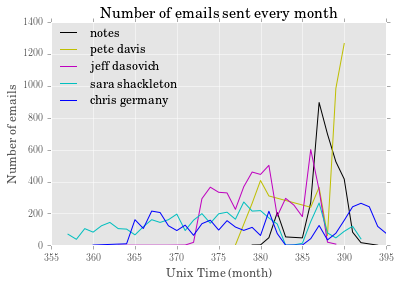

In [10]:
plt.figure()
# Plots
colors = list("rgbcmyk")
for e in most_prolific_senders:
    x = most_prolific_senders[e][0]
    y = most_prolific_senders[e][1]
    plt.plot(x,y,color=colors.pop(),label = e)

# Legend
plt.title('Number of emails sent every month')
plt.grid(True)
plt.xlabel("Unix Time (month)")
plt.ylabel("Number of emails")
plt.legend(loc=2, borderaxespad=0.,frameon=False)
plt.savefig('requirement_2.png', format='png',dpi=500)

## Receivers

In [11]:
unique_incoming_contacts = dict.fromkeys(prolific_senders[:top],[])
count_incoming_contacts = dict.fromkeys(prolific_senders[:top],[])
for i in range(data.shape[0]-1,-1,-1):
    recipients = extract_email(re.split('\|',data[i,2]))
    sender = data[i,1]
    if not (sender in unique_incoming_contacts):
        for r in recipients:
            if r in prolific_senders[:top]:
                time = int(data[i,0])/(1000*3600*24*30)
                count_incoming_contacts[r] = np.append(time,count_incoming_contacts[r])
                unique_incoming_contacts[r] = np.append(sender,count_incoming_contacts[r])
for e in count_incoming_contacts:
    count_incoming_contacts[e] = np.unique(count_incoming_contacts[e], return_counts=True)

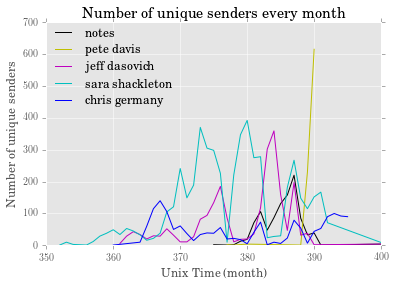

In [12]:
plt.figure()
# Plots
colors = list("rgbcmyk")
for e in count_incoming_contacts:
    x = count_incoming_contacts[e][0]
    y = count_incoming_contacts[e][1]
    plt.plot(x,y,color=colors.pop(),label = e)

# Legend
plt.title('Number of unique senders every month')
plt.grid(True)
plt.xlabel('Unix Time (month)')
plt.ylabel('Number of unique senders')
plt.legend(loc=2, borderaxespad=0.,frameon=False)
plt.savefig('requirement_3.png', format='png',dpi=500)